###  Import

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

import itertools
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/tami/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import cleaned dataset
df = pd.read_csv('persistence/cleaned_data_2018-06-19.csv', parse_dates=True, index_col='date')
df.info()

In [4]:
pm25 = df['pm25']

###  Modeling
#### 1. Classical Statistical Modeling
##### 1.1 ARIMA  

                              ARMA Model Results                              
Dep. Variable:                   pm25   No. Observations:                41757
Model:                     ARMA(1, 0)   Log Likelihood             -192487.230
Method:                       css-mle   S.D. of innovations             24.306
Date:                Tue, 19 Jun 2018   AIC                         384980.461
Time:                        18:59:43   BIC                         385006.380
Sample:                    01-02-2010   HQIC                        384988.648
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.5397      3.348     29.432      0.000      91.978     105.102
ar.L1.pm25     0.9645      0.001    746.634      0.000       0.962       0.967
                                    Roots           

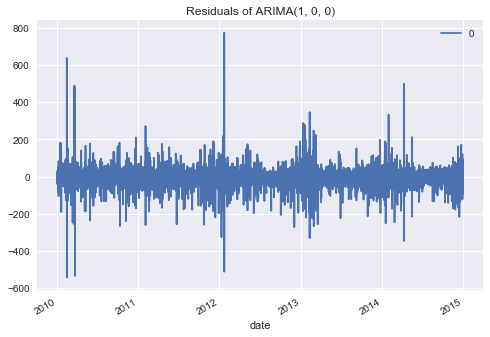

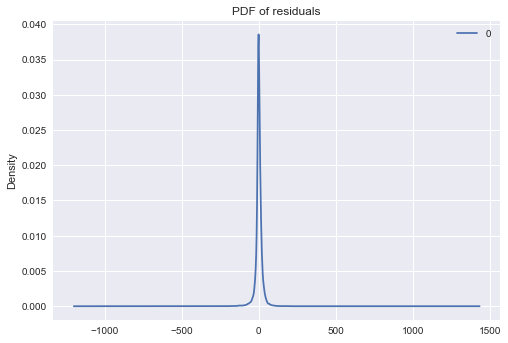

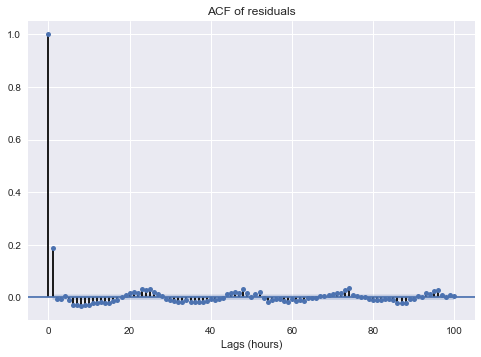

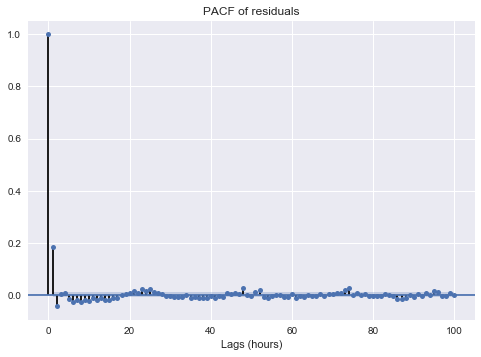

In [5]:
# Parameters suggested by figures in the Time Series Analysis
#    AR-term =  p  =  1  # because PACF first crosses significance line after lag-1
#    I-term  =  d  =  0  # because original series is stationary
#    MA-term =  q  =  0  # because ACF decays gradually 

model = ARIMA(pm25, order=(1, 0, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

plt.figure(1)
residuals.plot()
plt.title('Residuals of ARIMA(1, 0, 0)')

plt.figure(2)
residuals.plot(kind='kde');
plt.title('PDF of residuals')

plt.figure(3)
plot_acf(residuals, lags=100)  
plt.title('ACF of residuals')
plt.xlabel('Lags (hours)');

plt.figure(4)
plot_pacf(residuals, lags=100)  
plt.title('PACF of residuals')
plt.xlabel('Lags (hours)');

print(residuals.describe());

- Residual PACF shows a spike at lag-1. We should try increasing p by 1.

                              ARMA Model Results                              
Dep. Variable:                   pm25   No. Observations:                41757
Model:                     ARMA(2, 0)   Log Likelihood             -191701.544
Method:                       css-mle   S.D. of innovations             23.853
Date:                Tue, 19 Jun 2018   AIC                         383411.089
Time:                        18:59:45   BIC                         383445.647
Sample:                    01-02-2010   HQIC                        383422.006
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.6132      2.757     35.770      0.000      93.210     104.016
ar.L1.pm25     1.1499      0.005    239.435      0.000       1.140       1.159
ar.L2.pm25    -0.1922      0.005    -40.016      0.0

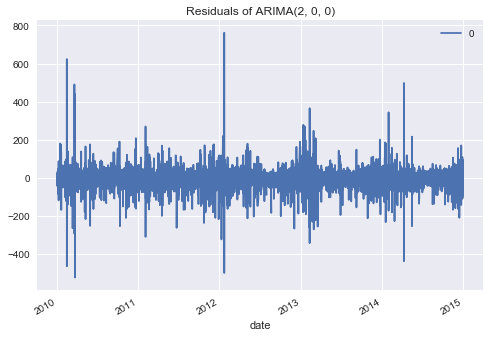

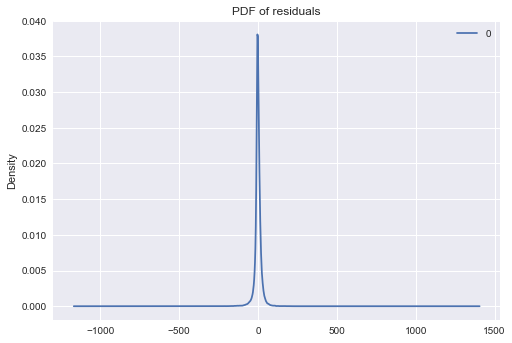

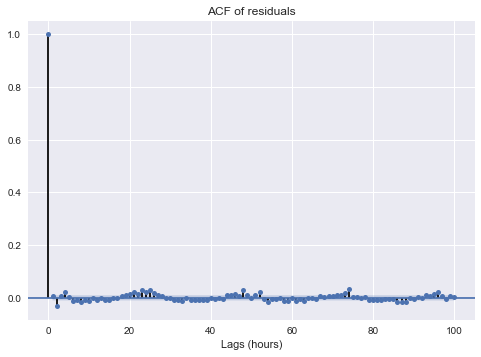

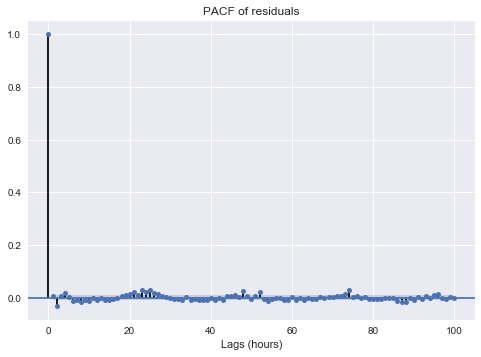

In [6]:
model = ARIMA(pm25, order=(2, 0, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

plt.figure(1)
residuals.plot()
plt.title('Residuals of ARIMA(2, 0, 0)')

plt.figure(2)
residuals.plot(kind='kde');
plt.title('PDF of residuals')

plt.figure(3)
plot_acf(residuals, lags=100)  
plt.title('ACF of residuals')
plt.xlabel('Lags (hours)');

plt.figure(4)
plot_pacf(residuals, lags=100)  
plt.title('PACF of residuals')
plt.xlabel('Lags (hours)');

print(residuals.describe());

- Residual ACF and PACF no longer display spikes. This suggests we have found the best parameters for our non-seasonal ARIMA(2,0,0). 

- However:
1. Residual ACF and PACF display a low-level cyclical pattern (in other words, the residuals are not quite stationary: there is a wave at a period of ~24 lags or 1 day). 

2. The sum of the AR coefficients is very close to 1 (0.9577).

Both 1 and 2 are suggest that we should increase the order of differencing. And due to the seasonal structure seen in the data, we choose to use a seasonal difference.

##### 1.2 Seasonal ARIMA  -- parameter selection via Box-Jenkins methodology

                                 Statespace Model Results                                 
Dep. Variable:                               pm25   No. Observations:                41757
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 24)   Log Likelihood             -199430.205
Date:                            Tue, 19 Jun 2018   AIC                         398868.411
Time:                                    19:00:42   BIC                         398902.969
Sample:                                01-02-2010   HQIC                        398879.327
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1327      0.001    783.244      0.000       1.130       1.136
ar.L2         -0.1856      0.002   

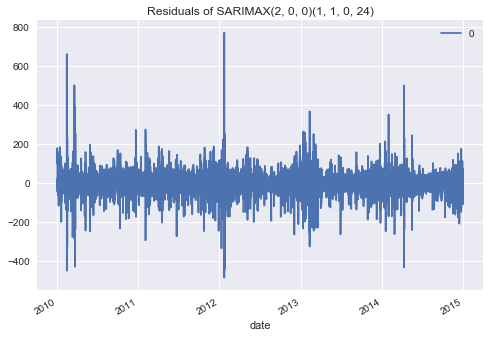

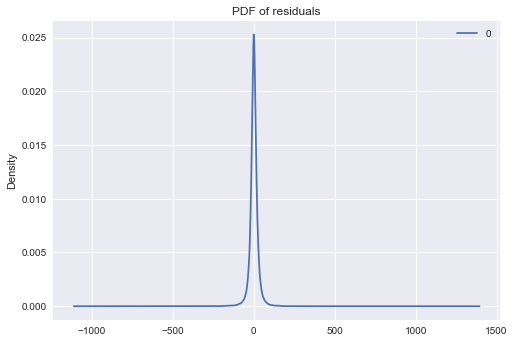

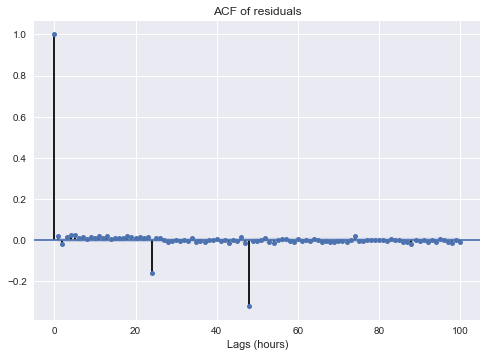

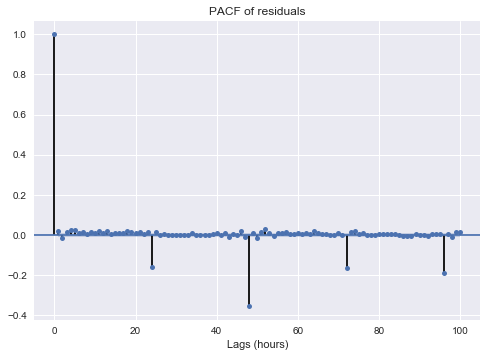

In [7]:
#  (p,d,q) = (2,0,0)
#  Seasonal Parameters suggested by residual figures of the ARIMA model
#    Period           =  s  = 24  # because original series, ACF, PACF, and residual ACF, residual PACF show a 24-hour period.
#    SAR-term         =  P  =  1  # because ACF is positive at lag-s
#    Seas. Diff. term =  D  =  1  # because original series, ACF, PACF, and residual ACF, residual PACF show a 24-hour period.
#    SMA-term         =  Q  =  0  # because ACF is not negative at lag-s.
#  (P,D,Q)s = (1, 1, 0, 24) or (0, 1, 0, 24) >>>> Seasonal Random Walk model plus AR(2) term

model = SARIMAX(pm25, order=(2, 0, 0), seasonal_order=(1, 1, 0, 24))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

plt.figure(1)
residuals.plot()
plt.title('Residuals of SARIMAX(2, 0, 0)(1, 1, 0, 24)')

plt.figure(2)
residuals.plot(kind='kde');
plt.title('PDF of residuals')

plt.figure(3)
plot_acf(residuals, lags=100)  
plt.title('ACF of residuals')
plt.xlabel('Lags (hours)');

plt.figure(4)
plot_pacf(residuals, lags=100)  
plt.title('PACF of residuals')
plt.xlabel('Lags (hours)');

print(residuals.describe());

- Residual PACF still shows spikes at s-lags. Add another SAR term (P).

                                 Statespace Model Results                                 
Dep. Variable:                               pm25   No. Observations:                41757
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 24)   Log Likelihood             -197172.716
Date:                            Tue, 19 Jun 2018   AIC                         394355.432
Time:                                    19:04:34   BIC                         394398.630
Sample:                                01-02-2010   HQIC                        394369.077
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1319      0.001    830.747      0.000       1.129       1.135
ar.L2         -0.1801      0.001   

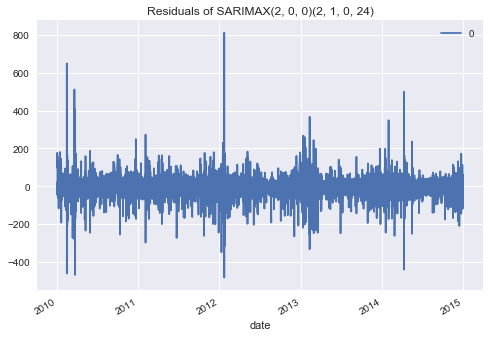

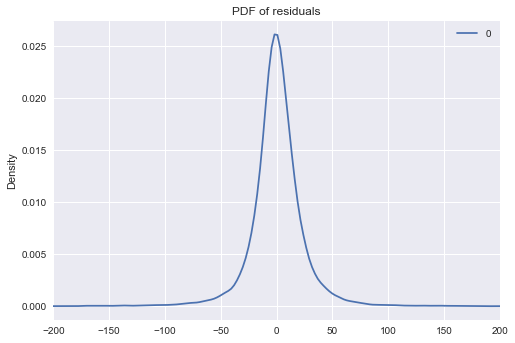

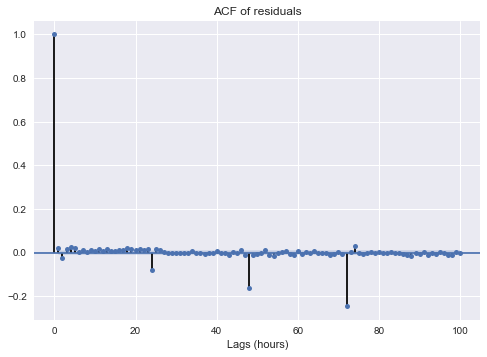

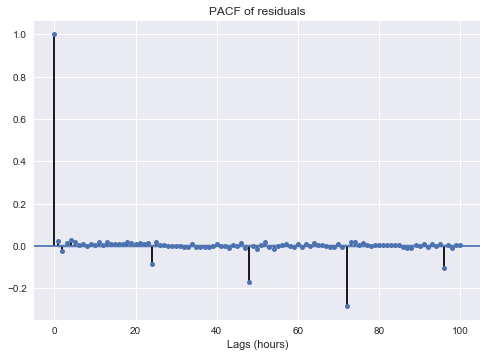

In [8]:
model = SARIMAX(df['pm25'], order=(2, 0, 0), seasonal_order=(2, 1, 0, 24))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

plt.figure(1)
residuals.plot()
plt.title('Residuals of SARIMAX(2, 0, 0)(2, 1, 0, 24)')

plt.figure(2)
residuals.plot(kind='kde');
plt.title('PDF of residuals')
plt.xlim([-75, 75])

plt.figure(3)
plot_acf(residuals, lags=100)  
plt.title('ACF of residuals')
plt.xlabel('Lags (hours)');

plt.figure(4)
plot_pacf(residuals, lags=100)  
plt.title('PACF of residuals')
plt.xlabel('Lags (hours)');

print(residuals.describe());

Are errors Gaussian? Are they centered on zero? (non-zero mean of residuals means there is a bias in the prediction)

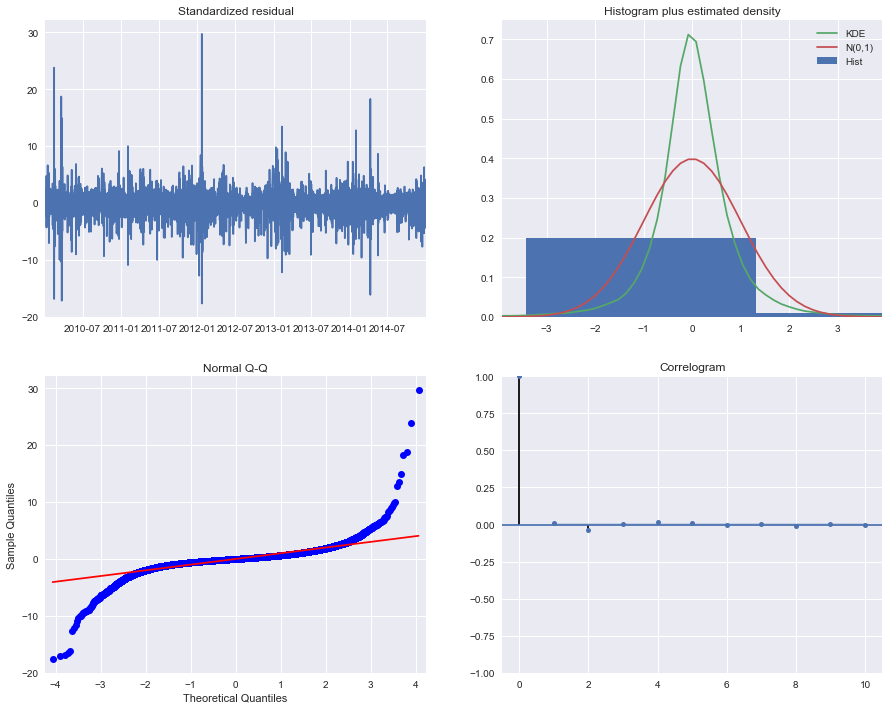

In [9]:
model_fit.plot_diagnostics(figsize=(15, 12));

Using s=8760 crashes the kernel. We will stay with s=24.

##### 1.3  Parameter Selection for SARIMAX via gridsearch

In [10]:
# Gridsearch manually to select the optimal parameter values for SARIMAX
# scoring metric = AIC (Akaike Information Criterion), lowest score is best

# define grid to search for p, d, and q
p = range(0,3)
d = q = range(0, 2)
pdq = list(itertools.product(p,d,q))

# define grid to search for P, D, and Q
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p,d,q))]

# Split into Train and Test sets
size = int(len(pm25)*0.7)
train, test = pm25[0:size], pm25[size:len(pm25)]

In [11]:
train.shape
test.shape

(29229,)

(12528,)

In [12]:
warnings.filterwarnings("ignore")

start = time()
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
model = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try: 
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = model
        except:
            continue  # some parameter combinations may cause numerical misspecification which will throw exceptions. catch and ignore these combinations. 
print(time()-start)

ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:357666.4993200467
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:346258.447070517
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:349166.4986357713
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:346299.77456957736
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:350193.5373639157
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:342734.23740490177
ARIMA(0, 0, 0)x(2, 0, 0, 24) - AIC:347592.16440355737
ARIMA(0, 0, 0)x(2, 0, 1, 24) - AIC:343156.6248129007
ARIMA(0, 0, 0)x(2, 1, 0, 24) - AIC:348059.24699225236
ARIMA(0, 0, 0)x(2, 1, 1, 24) - AIC:342465.5961428222
ARIMA(0, 0, 1)x(0, 0, 0, 24) - AIC:335832.44889533566
ARIMA(0, 0, 1)x(0, 0, 1, 24) - AIC:325775.5220303773
ARIMA(0, 0, 1)x(0, 1, 0, 24) - AIC:324322.6480188399
ARIMA(0, 0, 1)x(0, 1, 1, 24) - AIC:314970.90856501006
ARIMA(0, 0, 1)x(1, 0, 0, 24) - AIC:319041.0621385271
ARIMA(0, 0, 1)x(1, 0, 1, 24) - AIC:315156.38361215754
ARIMA(0, 0, 1)x(1, 1, 0, 24) - AIC:320018.3744697178
ARIMA(0, 0, 1)x(1, 1, 1, 24) - AIC:312353.75755830365
ARIMA(0, 0, 1)x(2, 0, 0, 24) - AIC:3171

In [13]:
# The optimal parameters are:
# lag-order = p = 2
# degree-of-differencing = d = 0
# order-of-moving-average = q = 1
# PDQ = (2,1,1)

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


# AIC measures trade-off between goodness of fit of the model and the complexity of the model. 

Best SARIMAXNonexNone12 model - AIC:inf


##### 1.4 Fitting the SARIMAX

In [ ]:
model = SARIMAX(train, order=(2,0,1), seasonal_order=(2,1,1,24), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary()); #.tables[1])

results.plot_diagnostics(figsize=(16,10));
plt.tight_layout();

##### 1.5 Predicting with the SARIMAX

In [ ]:
# # Split into Train and Test sets
# size = int(len(pm25)*0.7)
# train, test = pm25[0:size], X[size:len(pm25)]

# Keep track of all observations + forecasts
history = [x for x in train]

predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(), seasonal_order=())
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(typ='levels')  # return forecasted values to original scale
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f', % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['expected values', 'forecasted values'])

Are the expected values close to the rolling forecast predictions? Do they show similar trend? Are they on the correct scale?